<a href="https://colab.research.google.com/github/varisvithitpaiboon/Proactive-Customer-Experience-Management-Using-Predictive-Analytics-on-WiFi-Behavior-Data/blob/main/UCL_Lifemote_Predictive_Call_Anomaly_Feature_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [ ]:
!pip -q install optuna
!pip -q install catboost
!pip -q install tsfresh[dask]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 27.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
from datetime import timedelta
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer, average_precision_score
from sklearn.model_selection import cross_val_score
import optuna
import shap
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
import IPython.display as display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import gc
import tsfresh
from tsfresh import select_features
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import average_precision_score, ndcg_score
import stumpy
from tqdm import tqdm
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedShuffleSplit
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import average_precision_score
from xgboost import XGBClassifier
from tsfresh.feature_selection.relevance import calculate_relevance_table
from xgboost import XGBClassifier
import shap
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

# Import data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Network Data

In [ ]:
# Set your folder path inside Google Drive
network_folder_path = '/content/drive/MyDrive/UCL-Lifemote/network_data'
chunksize = 50000  # Adjust based on available RAM

# List all CSV files in the folder
network_csv_files = [f for f in os.listdir(network_folder_path) if f.endswith('.csv')]

# Initialize an empty list to collect all chunks
dataframes = []

# Process files in chunks
for file in tqdm(network_csv_files, desc="Processing CSV files"):
    full_path = os.path.join(network_folder_path, file)
    try:
        chunk_iter = pd.read_csv(full_path, chunksize=chunksize)
        for i, chunk in enumerate(chunk_iter):
            chunk['source_file'] = file  # Optional: tag origin
            chunk['chunk_number'] = i    # Optional: track chunk
            dataframes.append(chunk)     # Store each chunk temporarily
    except Exception as e:
        print(f" Failed to load {file}: {e}")

# Combine all chunks into one DataFrame
if dataframes:
    df_network = pd.concat(dataframes, ignore_index=True)
    print(f" Final df_network shape: {df_network.shape}")
else:
    print(" No valid data was read from the folder.")


Processing CSV files: 100%|██████████| 30/30 [02:01<00:00,  4.05s/it]


 Final df_network shape: (13605240, 96)


In [ ]:
print(df_network['analysis_date'].value_counts(dropna=False))

analysis_date
2025-07-10 00:00:00    458053
2025-07-09 00:00:00    457649
2025-07-07 00:00:00    456972
2025-07-08 00:00:00    456894
2025-07-04 00:00:00    456205
2025-07-06 00:00:00    456075
2025-07-05 00:00:00    456067
2025-07-03 00:00:00    455628
2025-07-02 00:00:00    455247
2025-07-01 00:00:00    455055
2025-06-30 00:00:00    454728
2025-06-27 00:00:00    454109
2025-06-28 00:00:00    453884
2025-06-26 00:00:00    453863
2025-06-29 00:00:00    453761
2025-06-25 00:00:00    452783
2025-06-24 00:00:00    452671
2025-06-23 00:00:00    452463
2025-06-20 00:00:00    451960
2025-06-18 00:00:00    451788
2025-06-19 00:00:00    451544
2025-06-21 00:00:00    451520
2025-06-22 00:00:00    451493
2025-06-17 00:00:00    451360
2025-06-16 00:00:00    451254
2025-06-13 00:00:00    450820
2025-06-14 00:00:00    450519
2025-06-12 00:00:00    450424
2025-06-15 00:00:00    450410
2025-06-11 00:00:00    450041
Name: count, dtype: int64


In [ ]:
df_network.head()

,device_id,analysis_date,id,analysis_id,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,...,mid_fwa_count,poor_iot_weighted_samples_24,poor_active_iot_weighted_samples_24,channel_changes_count_24,channel_changes_count_5,channel_changes_count_6,mem_usage,high_mem_usage_samples,source_file,chunk_number
0,DEVICE_ID_961c5550db,2025-06-11 00:00:00,ID_b0a43c9bc9,ANALYSIS_ID_e1e909f586,0,0,0,1878,2174,1853,...,0,14,1,0.0,0.0,NaN,41.55,0,cpe_status_2025-06-11_ready.csv,0
1,DEVICE_ID_39190265c2,2025-06-11 00:00:00,ID_5c687e45be,ANALYSIS_ID_05f8ccfe3e,0,0,0,2,2496,1,...,0,0,0,0.0,0.0,NaN,58.12,0,cpe_status_2025-06-11_ready.csv,0
2,DEVICE_ID_77a16a8d79,2025-06-11 00:00:00,ID_11db07b498,ANALYSIS_ID_8df4ed77df,0,0,0,0,818,0,...,0,0,0,0.0,0.0,NaN,39.60,0,cpe_status_2025-06-11_ready.csv,0
3,DEVICE_ID_905832b06c,2025-06-11 00:00:00,ID_393c580a22,ANALYSIS_ID_8ed247d1a2,0,0,0,1634,3787,1625,...,0,4,0,0.0,0.0,NaN,40.48,0,cpe_status_2025-06-11_ready.csv,0
4,DEVICE_ID_8f1dbe5a7f,2025-06-11 00:00:00,ID_67ec92db86,ANALYSIS_ID_55850a81fe,0,0,0,1488,1142,6,...,0,0,0,0.0,0.0,NaN,58.62,0,cpe_status_2025-06-11_ready.csv,0


## Import Call Data

In [ ]:
# Set your folder path inside Google Drive
call_file_path = '/content/drive/MyDrive/UCL-Lifemote/call_data/df_call_final.csv'

# Read the CSV file
df_call = pd.read_csv(call_file_path)

# Preview
print(f"df_call shape: {df_call.shape}")

df_call shape: (47355, 7)


In [ ]:
df_call.head()

,id,resource_id,created_at,user_id,group_name,username,resource
0,1094528,RESOURCE_ID_b1a07b8694,2025-06-11 02:34:53.355349,465,first-line,USERNAME_7cd244d515,home
1,1094529,RESOURCE_ID_072bdfd2f5,2025-06-11 02:34:54.344923,465,first-line,USERNAME_7cd244d515,cpe
2,1094530,RESOURCE_ID_aa2d955d4e,2025-06-11 02:34:54.400746,465,first-line,USERNAME_7cd244d515,cpe
3,1094531,RESOURCE_ID_b1a07b8694,2025-06-11 02:34:54.455219,465,first-line,USERNAME_7cd244d515,cpe
4,1094532,RESOURCE_ID_24e3e9b021,2025-06-11 02:34:54.726571,465,first-line,USERNAME_7cd244d515,cpe


# Data Preprocessing

## Label flag_call and ensure datetime format

In [ ]:
# Flag Call = 1
df_call["flag_call"] = 1

In [ ]:
# Ensure 'analysis_date' is in datetime format
df_network['analysis_date'] = pd.to_datetime(df_network['analysis_date']).dt.normalize()

# Ensure 'created_at' is in datetime format
df_call['created_at'] = pd.to_datetime(df_call['created_at']).dt.normalize()

# Preview values and types
print(df_network['analysis_date'].head())
print(df_call['created_at'].head())

0   2025-06-11
1   2025-06-11
2   2025-06-11
3   2025-06-11
4   2025-06-11
Name: analysis_date, dtype: datetime64[ns]
0   2025-06-11
1   2025-06-11
2   2025-06-11
3   2025-06-11
4   2025-06-11
Name: created_at, dtype: datetime64[ns]


## Extract device_id

In [ ]:
# Extract resource_id
df_call['resource_id'] = df_call['resource_id'].str[12:]
df_call['resource_id'].head(5)

# Count unique customer of df_call
print(f"Number of customers in df_call: {df_call['resource_id'].nunique()}")

Number of customers in df_call: 13401


In [ ]:
# Extract device_id
df_network['device_id'] = df_network['device_id'].str[10:]
df_network['device_id'].head(1)

# count unique customer of df_network
print(f"Number of customers in df_network {df_network['device_id'].nunique()}")

Number of customers in df_network 475660


## Drop duplicate calls

In [ ]:
# Drop duplicate call on the same day
df_call = df_call.drop_duplicates(subset=['resource_id', 'created_at'], keep='first')
# df_call.head()
df_call.shape

(14924, 8)

In [ ]:
# Count how many customer_ids appear in both DataFrames
overlap_count = len(set(df_network['device_id']) & set(df_call['resource_id']))
print(f"Overlapping device_id & resource_id count: {overlap_count}")

## Merge df_network and df_call

In [ ]:
# Merge df_network and df_call
def memory_efficient_merge(df_network, df_call, chunk_size=50_000):
    # Optimize data types before merging
    df_network['device_id'] = df_network['device_id'].astype('category')
    df_call['resource_id'] = df_call['resource_id'].astype('category')

    # Downcast numeric columns in df_call
    df_call['flag_call'] = pd.to_numeric(df_call['flag_call'], downcast='integer')

    # Convert string columns to category if they have low cardinality
    for col in ['group_name', 'resource']:
        if df_call[col].nunique() / len(df_call[col]) < 0.5:
            df_call[col] = df_call[col].astype('category')

    # Prepare the right dataframe columns to merge
    merge_cols = ['resource_id', 'group_name', 'resource', 'created_at', 'flag_call']
    df_call_reduced = df_call[merge_cols].copy()

    # Process in chunks
    chunks = []
    for i in range(0, len(df_network), chunk_size):
        network_chunk = df_network.iloc[i:i+chunk_size]

        # Merge with optimized memory
        merged_chunk = network_chunk.merge(
            df_call_reduced,
            how='left',
            left_on=['device_id', 'analysis_date'],
            right_on=['resource_id', 'created_at']
        )

        # Optimize the merged chunk
        merged_chunk['flag_call'] = merged_chunk['flag_call'].fillna(0).astype('int8')

        # Append to results and clean up
        chunks.append(merged_chunk)
        del network_chunk, merged_chunk
        gc.collect()

    # Concatenate all chunks
    final_df = pd.concat(chunks, ignore_index=True)

    # Clean up
    del chunks, df_call_reduced
    gc.collect()

    return final_df

df_merged = memory_efficient_merge(df_network, df_call)

In [ ]:
del df_network, df_call

gc.collect()

0

In [ ]:
# Select Sample devices to run the model, whle keeping proportion of fault positive similar to original dataset
def sample_complete_devices(df, target_devices=20_000, fault_col='flag_call', date_col='analysis_date', random_state=42):

    # Calculate original proportions
    original_row_ratio = df[fault_col].mean()
    device_status = df.groupby('device_id')[fault_col].mean().gt(0)
    original_device_ratio = device_status.mean()

    print(f"Original row fault ratio: {original_row_ratio:.5f}")
    print(f"Original device fault ratio: {original_device_ratio:.5f}")

    # Get complete devices (all dates present)
    n_dates = df[date_col].nunique()
    complete_devices = (df.groupby('device_id')[date_col]
                       .nunique()
                       .loc[lambda x: x == n_dates]
                       .index)
    df_complete = df[df['device_id'].isin(complete_devices)]

    # Classify complete devices
    device_status = df_complete.groupby('device_id')[fault_col].mean().gt(0)
    faulty_devices = device_status[device_status].index
    healthy_devices = device_status[~device_status].index

    # Calculate required samples
    n_faulty = int(round(target_devices * original_device_ratio))
    n_faulty = min(n_faulty, len(faulty_devices))
    n_healthy = target_devices - n_faulty

    # Sample devices
    np.random.seed(random_state)
    sampled_faulty = np.random.choice(faulty_devices, n_faulty, replace=False)
    sampled_healthy = np.random.choice(healthy_devices, n_healthy, replace=False)

    # Combine sampled devices
    sampled_devices = np.concatenate([sampled_faulty, sampled_healthy])
    df_sampled = df_complete[df_complete['device_id'].isin(sampled_devices)]  # Consistent naming

    # Calculate scaling factor to match original row ratio
    current_row_ratio = df_sampled[fault_col].mean()
    if current_row_ratio > 0:
        scale_factor = original_row_ratio / current_row_ratio
        if scale_factor < 1:
            # Downsample fault rows
            fault_rows = df_sampled[df_sampled[fault_col] == 1]
            keep_prob = min(scale_factor, 1.0)
            mask = np.random.random(len(fault_rows)) < keep_prob
            df_sampled = pd.concat([
                df_sampled[df_sampled[fault_col] == 0],
                fault_rows[mask]
            ])

    # Verification
    verification = {
        'total_devices': df_sampled['device_id'].nunique(),
        'faulty_devices': len(sampled_faulty),
        'row_fault_ratio': df_sampled[fault_col].mean(),
        'device_fault_ratio': (df_sampled.groupby('device_id')[fault_col].mean() > 0).mean(),
        'date_completeness': (df_sampled.groupby('device_id')[date_col].nunique() == n_dates).all(),
        'total_rows': len(df_sampled)
    }

    print("\n=== Results ===")
    print(f"Sampled devices: {verification['total_devices']}")
    print(f"Faulty devices: {verification['faulty_devices']}")
    print(f"Achieved row fault ratio: {verification['row_fault_ratio']:.5f}")
    print(f"Device fault ratio: {verification['device_fault_ratio']:.5f}")
    print(f"All dates present: {verification['date_completeness']}")
    print(f"Total rows: {verification['total_rows']}")

    return df_sampled

# Usage
df_merged = sample_complete_devices(df_merged)

Original row fault ratio: 0.00074
Original device fault ratio: 0.01865

=== Results ===
Sampled devices: 20000
Faulty devices: 373
Achieved row fault ratio: 0.00071
Device fault ratio: 0.01865
All dates present: True
Total rows: 600000


In [ ]:
# Count positive and negative flag_call values
call_counts = df_merged['flag_call'].value_counts().sort_index()

# Print results
print(" Flag Call Counts:")
print(f"Negative (0): {call_counts.get(0, 0)}")
print(f"Positive (1): {call_counts.get(1, 0)}")

del call_counts

gc.collect()

 Flag Call Counts:
Negative (0): 599572
Positive (1): 428


0

In [ ]:
df_merged.head()

,device_id,analysis_date,id,analysis_id,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,...,channel_changes_count_6,mem_usage,high_mem_usage_samples,source_file,chunk_number,resource_id,group_name,resource,created_at,flag_call
13,7f443695a6,2025-06-11,ID_8a2ac2b198,ANALYSIS_ID_31d3810016,0,0,0,3649,2846,3435,...,NaN,40.43,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
31,7d2bbf8463,2025-06-11,ID_ea4f03ae88,ANALYSIS_ID_6a66dea521,0,0,0,2791,2485,1916,...,NaN,48.33,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
55,0081311cd3,2025-06-11,ID_3a9e5432f1,ANALYSIS_ID_eb9f1fd007,0,0,0,4572,2192,1890,...,NaN,59.21,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
67,71518abf57,2025-06-11,ID_5e077d4dff,ANALYSIS_ID_015d1ae49a,0,0,0,676,3908,346,...,NaN,21.38,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
108,1785e6457a,2025-06-11,ID_4972f96173,ANALYSIS_ID_2da83f8d34,1,0,0,2790,3569,1433,...,NaN,47.06,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0


# Data Cleaning

In [ ]:
# Drop rows with missing flag_call
original_len = len(df_merged)

df_merged = df_merged.dropna(subset=['flag_call']).reset_index(drop=True)

print(f"Removed {original_len - len(df_merged)} rows with missing flag_call")

del original_len

gc.collect()

Removed 0 rows with missing flag_call


0

In [ ]:
# Check which columns are completely empty (all values are NaN)
empty_columns = df_merged.columns[df_merged.isnull().all()].tolist()

# Print result
if empty_columns:
    print(f"Number of rows and columns: {df_merged.shape}")
    print(f"Number of empty columns: {len(empty_columns)}")
    print(f"Empty column names: {(empty_columns)}")
else:
    print("No empty columns")

Number of rows and columns: (600000, 101)
Number of empty columns: 11
Empty column names: ['cpu_temp', 'dsl_status', 'greedy_status', 'dsl_connection_stability_status', 'dsl_rate_stability_status', 'congestion_6_status', 'wifi_standard_24', 'wifi_standard_5', 'wifi_standard_6', 'fwa_quality_status', 'channel_changes_count_6']


In [ ]:
del empty_columns

gc.collect()

0

In [ ]:
# Drop NaN columns
df_merged = df_merged.dropna(axis=1, how='all')
print(f"Number of rows and columns: {df_merged.shape}")

Number of rows and columns: (600000, 90)


In [ ]:
# Calculate percentage of non-null values for each column
filling_rates = 100 * df_merged.count() / df_merged.shape[0]

# Round to 2 decimal places
filling_rates = filling_rates.round(2)

# Identify columns with < 50% filled
low_fill_columns = filling_rates[filling_rates < 50].index.tolist()

# Drop those columns
df_merged = df_merged.drop(columns=low_fill_columns)

# Print summary
print(f"Dropped {len(low_fill_columns)}")
print(f"low-filling columns (<50% filled): {low_fill_columns}")
print(f"New shape: {df_merged.shape}")

del filling_rates
del low_fill_columns

gc.collect()

Dropped 7
low-filling columns (<50% filled): ['legacy_status', 'repeater_status', 'max_outage_time', 'resource_id', 'group_name', 'resource', 'created_at']
New shape: (600000, 83)


0

In [ ]:
# List of columns to keep even if they have constant values
columns_to_keep = ['analysis_date', 'flag_call']

# Identify constant columns excluding the ones to keep
constant_columns = [
    col for col in df_merged.columns
    if df_merged[col].nunique(dropna=False) == 1 and col not in columns_to_keep
]

# Drop those columns
df_merged = df_merged.drop(columns=constant_columns)

# Print summary
print(f"Dropped {len(constant_columns)}")
print(f"constant columns: {constant_columns}")

del columns_to_keep
del constant_columns

gc.collect()

Dropped 20
constant columns: ['dsl_download_bottleneck_count', 'dsl_upload_bottleneck_count', 'interfered_active_samples_24', 'interfered_samples_24', 'greedy_event_count', 'wifi_bottleneck_count', 'poor_greedy_event_count', 'total_samples_6', 'poor_samples_6', 'mid_samples_6', 'good_samples_6', 'total_active_samples_6', 'poor_active_samples_6', 'mid_active_samples_6', 'good_active_samples_6', 'sample_active_6_count', 'congested_sample_6_count', 'congested_sample_active_6_count', 'poor_fwa_count', 'mid_fwa_count']


0

In [ ]:
# Drop irrelavant columns
irrelevant_columns = ['source_file', 'id', 'analysis_id']

# Drop those columns
df_merged = df_merged.drop(columns=irrelevant_columns)

# Print summary
print(f"Dropped {len(irrelevant_columns)}")
print(f"New shape: {df_merged.shape}")

del irrelevant_columns

gc.collect()

Dropped 3
New shape: (600000, 60)


0

In [ ]:
# Calculate percentage of non-null values for each column
filling_rates = 100 * df_merged.count() / df_merged.shape[0]

# Round to 4 decimal places
filling_rates = filling_rates.round(4)

# Filter and sort columns with less than 100% filled
incomplete_columns = filling_rates[filling_rates < 100].sort_values(ascending=False)

# Print the result
if not incomplete_columns.empty:
    print("Columns with less than 100% non-null values (ascending):")
    print(incomplete_columns)
    print(len(incomplete_columns))

    # Calculate and print the number of missing rows for each incomplete column
    print("\nNumber of missing rows per incomplete column:")
    missing_counts = df_merged[incomplete_columns.index].isnull().sum()
    print(missing_counts)
else:
    print("All columns are 100% complete.")

Columns with less than 100% non-null values (ascending):
channel_changes_count_24             99.8690
channel_changes_count_5              99.8627
congestion_24_status                 99.8590
congestion_5_status                  99.8527
wifi_coverage_status                 97.2568
wifi_coverage_5_status               94.5172
poor_gw_candidate_rssi_samples_24    92.7900
poor_gw_candidate_rssi_samples_5     92.7900
wifi_qoe_status                      91.5580
wifi_coverage_24_status              84.7537
dtype: float64
10

Number of missing rows per incomplete column:
channel_changes_count_24               786
channel_changes_count_5                824
congestion_24_status                   846
congestion_5_status                    884
wifi_coverage_status                 16459
wifi_coverage_5_status               32897
poor_gw_candidate_rssi_samples_24    43260
poor_gw_candidate_rssi_samples_5     43260
wifi_qoe_status                      50652
wifi_coverage_24_status              9147

## Clean missing rows using backward fill

In [ ]:
# Sort analysis_date and device_id
df_merged = df_merged.sort_values(['device_id', 'analysis_date'])

# Define columns that need to be fill
columns_to_fill = incomplete_columns.index

# Backward Fill
for col in columns_to_fill:
    df_merged[col] = df_merged.groupby('device_id')[col].transform('bfill')

# Report how many values are still missing
missing_summary = df_merged[columns_to_fill].isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

if missing_summary.empty:
    print("All missing values filled successfully.")
else:
    print("Remaining missing values after fill:")
    print(missing_summary)

Remaining missing values after fill:
channel_changes_count_24               765
channel_changes_count_5                775
congestion_24_status                   825
congestion_5_status                    835
wifi_coverage_status                  8453
wifi_coverage_5_status               16021
poor_gw_candidate_rssi_samples_24    43260
poor_gw_candidate_rssi_samples_5     43260
wifi_qoe_status                      16739
wifi_coverage_24_status              29280
dtype: int64


In [ ]:
del incomplete_columns
del filling_rates
del columns_to_fill
del missing_summary

gc.collect()

0

In [ ]:
# Count missing rows before dropping
missing_rows = df_merged.shape[0] - df_merged.dropna().shape[0]

# Drop missing rows
df_merged = df_merged.dropna()

# Print summary
print(f"Dropped {missing_rows} rows with missing values")
print(f"New shape: {df_merged.shape}")

del missing_rows

gc.collect()

Dropped 80545 rows with missing values
New shape: (519455, 60)


0

In [ ]:
# Sort by time
df_merged = df_merged.sort_values('analysis_date')
print(df_merged['analysis_date'])

2692     2025-06-11
15260    2025-06-11
7661     2025-06-11
5019     2025-06-11
3630     2025-06-11
            ...    
599426   2025-07-10
597941   2025-07-10
594071   2025-07-10
584107   2025-07-10
585984   2025-07-10
Name: analysis_date, Length: 519455, dtype: datetime64[ns]


In [ ]:
# Count positive and negative flag_call values
call_counts = df_merged['flag_call'].value_counts().sort_index()

# Print results
print(" Flag Call Counts:")
print(f"Negative (0): {call_counts.get(0, 0)}")
print(f"Positive (1): {call_counts.get(1, 0)}")

del call_counts

gc.collect()

 Flag Call Counts:
Negative (0): 519137
Positive (1): 318


0

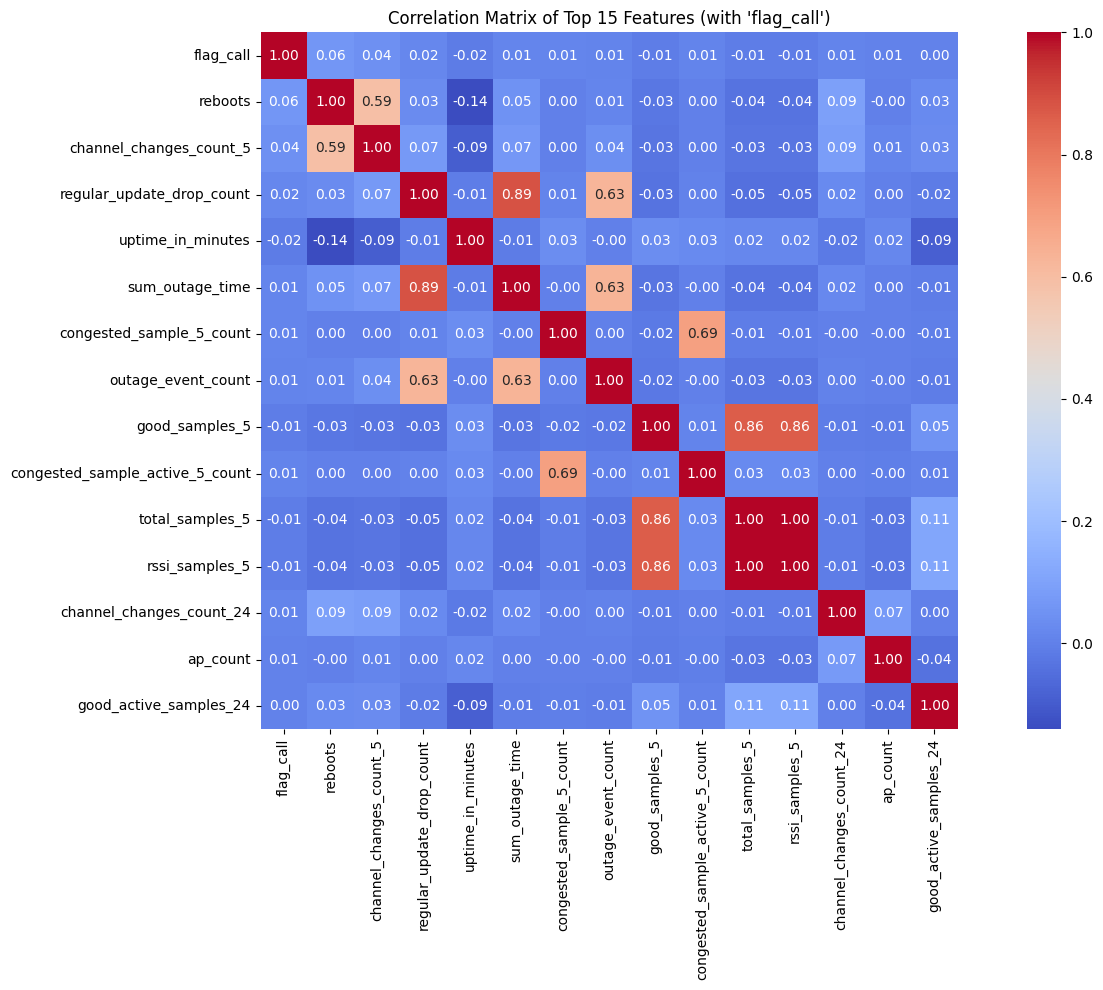

19119

In [ ]:
# Get only numeric columns
numeric_cols = df_merged.select_dtypes(include=["number"]).columns


# Drop columns with NaN
df_numeric = df_merged[numeric_cols].dropna(axis=1).copy()

# Get top 15 features most correlated (absolute) with flag_fault
top_15_corr_cols = (
    df_numeric.corrwith(df_merged["flag_call"])
    .abs()
    .sort_values(ascending=False)
    .head(15)
    .index
)

# Add 'flag_fault' to the selected columns
selected_cols = top_15_corr_cols.tolist()

# Plot correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(df_merged[selected_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Top 15 Features (with 'flag_call')")
plt.tight_layout()
plt.show()


del df_numeric

gc.collect()

# Feature Engineering - Predict Wifi Fault

## Ordinal Encoder

In [ ]:
# Ensure the column is string type
df_merged['congestion_5_status'] = df_merged['congestion_5_status'].astype(str)
df_merged['congestion_24_status'] = df_merged['congestion_24_status'].astype(str)
df_merged['band_usage_24_status'] = df_merged['band_usage_24_status'].astype(str)
df_merged['wifi_qoe_status'] = df_merged['wifi_qoe_status'].astype(str)

# # Define the order of categories
encoder = OrdinalEncoder(categories=[['POOR', 'MID', 'GOOD']])

# Apply ordinal encoding
df_merged['congestion_5_status'] = encoder.fit_transform(df_merged[['congestion_5_status']])
df_merged['congestion_24_status'] = encoder.fit_transform(df_merged[['congestion_24_status']])
df_merged['band_usage_24_status'] = encoder.fit_transform(df_merged[['band_usage_24_status']])
df_merged['wifi_qoe_status'] = encoder.fit_transform(df_merged[['wifi_qoe_status']])


In [ ]:
df_merged[['congestion_5_status', 'congestion_24_status', 'band_usage_24_status', 'wifi_qoe_status']]

,congestion_5_status,congestion_24_status,band_usage_24_status,wifi_qoe_status
2692,2.0,2.0,2.0,2.0
15260,2.0,1.0,2.0,0.0
7661,0.0,1.0,2.0,1.0
5019,0.0,2.0,2.0,2.0
3630,2.0,2.0,2.0,2.0
...,...,...,...,...
599426,2.0,2.0,2.0,2.0
597941,2.0,2.0,2.0,2.0
594071,2.0,2.0,2.0,2.0
584107,2.0,1.0,1.0,2.0


In [ ]:
df_merged[['congestion_5_status', 'congestion_24_status', 'band_usage_24_status', 'wifi_qoe_status']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 519455 entries, 2692 to 585984
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   congestion_5_status   519455 non-null  float64
 1   congestion_24_status  519455 non-null  float64
 2   band_usage_24_status  519455 non-null  float64
 3   wifi_qoe_status       519455 non-null  float64
dtypes: float64(4)
memory usage: 19.8 MB


In [ ]:
# Ensure the column is string type
df_merged['wifi_coverage_status'] = df_merged['wifi_coverage_status'].astype(str)
df_merged['wifi_coverage_24_status'] = df_merged['wifi_coverage_24_status'].astype(str)
df_merged['wifi_coverage_5_status'] = df_merged['wifi_coverage_5_status'].astype(str)

# Define the order of categories
encoder = OrdinalEncoder(categories=[['POOR', 'MID', 'HIGH']])

# Apply ordinal encoding
df_merged['wifi_coverage_status'] = encoder.fit_transform(df_merged[['wifi_coverage_status']])
df_merged['wifi_coverage_24_status'] = encoder.fit_transform(df_merged[['wifi_coverage_24_status']])
df_merged['wifi_coverage_5_status'] = encoder.fit_transform(df_merged[['wifi_coverage_5_status']])

In [ ]:
# Check data types for encoding columns
df_merged[['wifi_coverage_status', 'wifi_coverage_24_status', 'wifi_coverage_5_status']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 519455 entries, 2692 to 585984
Data columns (total 3 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   wifi_coverage_status     519455 non-null  float64
 1   wifi_coverage_24_status  519455 non-null  float64
 2   wifi_coverage_5_status   519455 non-null  float64
dtypes: float64(3)
memory usage: 15.9 MB


In [ ]:
df_merged[['wifi_coverage_status', 'wifi_coverage_24_status', 'wifi_coverage_5_status']]

,wifi_coverage_status,wifi_coverage_24_status,wifi_coverage_5_status
2692,2.0,2.0,1.0
15260,0.0,1.0,0.0
7661,2.0,2.0,2.0
5019,2.0,1.0,1.0
3630,2.0,0.0,2.0
...,...,...,...
599426,1.0,2.0,1.0
597941,2.0,2.0,2.0
594071,0.0,0.0,2.0
584107,2.0,2.0,2.0


In [ ]:
df_merged.shape

(519455, 60)

In [ ]:
df_merged.head()

,device_id,analysis_date,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,good_samples_5,poor_qoe_samples,...,total_samples_24_non_iot,band_usage_24_status,poor_iot_weighted_samples_24,poor_active_iot_weighted_samples_24,channel_changes_count_24,channel_changes_count_5,mem_usage,high_mem_usage_samples,chunk_number,flag_call
2692,0005970190,2025-06-11,0,0,0,368,1557,351,1311,11,...,368,2.0,0,0,0.0,0.0,57.21,0,1,0
15260,ab7f2270de,2025-06-11,0,0,0,70,3634,55,2081,142,...,70,2.0,0,0,0.0,0.0,59.47,0,6,0
7661,ab8b015600,2025-06-11,0,0,0,2850,7610,1882,5625,56,...,2850,2.0,0,0,0.0,0.0,52.19,0,3,0
5019,ab8dc0e35c,2025-06-11,0,0,0,3105,10386,231,10286,43,...,3105,2.0,9,1,0.0,0.0,25.17,0,2,0
3630,188a7fa684,2025-06-11,0,0,0,27,2001,5,1715,0,...,27,2.0,2,0,0.0,0.0,69.78,0,1,0


## Ensure device_id exist across all dates

In [ ]:
# Filter device_id that exist across all dates
def filter_devices_with_complete_dates(df, device_col='device_id', date_col='analysis_date'):

    # Ensure datetime format ---
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # Get all unique dates in the dataset ---
    all_dates = np.sort(df[date_col].unique())
    n_dates = len(all_dates)
    print(f" Total unique dates in dataset: {n_dates}")

    # Count unique dates per device ---
    device_date_counts = df.groupby(device_col)[date_col].nunique()

    # Identify complete devices ---
    complete_devices = device_date_counts[device_date_counts == n_dates].index
    n_complete = len(complete_devices)
    print(f" Found {n_complete} devices with complete date coverage (out of {len(device_date_counts)})")

    # Filter the DataFrame ---
    df_complete = df[df[device_col].isin(complete_devices)].copy()

    # Verify result ---
    remaining_devices = df_complete[device_col].nunique()
    assert remaining_devices == n_complete, " Filtering failed — counts don't match!"
    print(f" Final DataFrame contains {remaining_devices} devices with full date coverage")

    return df_complete

In [ ]:
df_merged = filter_devices_with_complete_dates(df_merged)

print(f' df_merged shape {df_merged.shape}')

 Total unique dates in dataset: 30
 Found 14799 devices with complete date coverage (out of 17904)
 Final DataFrame contains 14799 devices with full date coverage
 df_merged shape (443970, 60)


## Manual Feature Engineering

In [ ]:
# Create Manual Ferature Engineering
def manual_feature_engineering(df):
    # df = df.copy()

    # Ratios
    df['poor_coverage_ratio_24'] = df['poor_samples_24'] / (df['total_active_samples_24'] + 1e-6)
    df['poor_coverage_ratio_5'] = df['poor_samples_5'] / (df['total_active_samples_5'] + 1e-6)
    df['poor_coverage_ratio_total'] = (df['poor_samples_5'] + df['poor_samples_24']) / (df['total_active_samples_24'] + df['total_active_samples_5'] + 1e-6)

    df['active_poor_ratio_24'] = df['poor_active_samples_24'] / (df['total_active_samples_24'] + 1e-6)
    df['active_poor_ratio_5'] = df['poor_active_samples_5'] / (df['total_active_samples_5'] + 1e-6)
    df['active_poor_ratio_total'] = (df['poor_active_samples_24'] + df['poor_active_samples_5']) / (df['total_active_samples_24'] + df['total_active_samples_5'] + 1e-6)

    df['total_stations_per_hour'] = df['number_of_wifi_clients'] / (df['uptime_in_minutes'] / 60 + 1e-6)

    # -Band preference and congestion ratios
    df['congestion_ratio_24'] = df['congested_sample_24_count'] / (df['total_active_samples_24'] + df['total_active_samples_5'] + 1e-6)
    df['congestion_ratio_5'] = df['congested_sample_5_count'] / (df['total_active_samples_24'] + df['total_active_samples_5'] + 1e-6)

    return df


In [ ]:
df_merged = manual_feature_engineering(df_merged)

In [ ]:
df_merged.head()

,device_id,analysis_date,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,good_samples_5,poor_qoe_samples,...,flag_call,poor_coverage_ratio_24,poor_coverage_ratio_5,poor_coverage_ratio_total,active_poor_ratio_24,active_poor_ratio_5,active_poor_ratio_total,total_stations_per_hour,congestion_ratio_24,congestion_ratio_5
2692,0005970190,2025-06-11,0,0,0,368,1557,351,1311,11,...,0,0.000000,0.077093,0.050725,0.000000,0.037445,0.024638,0.110571,0.001449,0.000000
15260,ab7f2270de,2025-06-11,0,0,0,70,3634,55,2081,142,...,0,0.000000,0.983854,0.962105,0.000000,0.541442,0.529474,0.011102,0.732632,0.002105
7661,ab8b015600,2025-06-11,0,0,0,2850,7610,1882,5625,56,...,0,0.000000,0.002020,0.001364,0.000000,0.000000,0.000000,0.006389,0.047749,0.107776
5019,ab8dc0e35c,2025-06-11,0,0,0,3105,10386,231,10286,43,...,0,0.087379,0.004241,0.010920,0.009709,0.000000,0.000780,0.405742,0.007800,0.017161
47,ab8df22c51,2025-06-11,1,0,0,0,110,0,109,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.465031,0.000000,0.000000


## Lag Features

In [ ]:
# Generated 1-day lag features

def add_top_lag_features(df, group_col='device_id', target_col='flag_call',
                         n_features=20, lag_period=1, verbose=True):

    # Identify numeric columns (excluding target)
    numeric_cols = df.select_dtypes(include='number').columns.difference([target_col])

    # Compute lag features
    lag_suffix = f'.lag{lag_period}'
    df_lagged = df.groupby(group_col)[numeric_cols].shift(lag_period).add_suffix(lag_suffix)

    # Compute correlations
    cor_df = df_lagged.copy()
    cor_df[target_col] = df[target_col].values
    correlations = cor_df.corr()[target_col].drop(target_col)

    # Select top N features
    top_features = correlations.abs().nlargest(n_features)
    top_lag_cols = top_features.index.tolist()

    # Merge top features with original data
    df_output = pd.concat([df, df_lagged[top_lag_cols]], axis=1)

    # Print output
    if verbose:
        print(f"\nTop {n_features} lag-{lag_period} correlated features with {target_col}:")
        for col in top_lag_cols:
            print(f"{col:.<30} correlation = {correlations[col]:.4f}")
        print(f"\nAdded {len(top_lag_cols)} lag features to DataFrame")

    return df_output, correlations

## Create rolling delta featrues

In [ ]:
# Create day over day deltas od selected features
def compute_rolling_deltas(df, date_col='analysis_date', group_col='device_id'):

    # Sort by device and time
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values([group_col, date_col])

    # Define base variables
    base_vars = [
        "reboots", "script_boots", "ap_count", "total_samples_24", "total_samples_5",
        "good_samples_24", "good_samples_5", "poor_qoe_samples_24",
        "poor_iot_weighted_samples_24", "channel_changes_count_24",
        "mem_usage", "high_mem_usage_samples"
    ]

    # Add wildcard-matched variables
    pattern_vars = df.columns[df.columns.str.contains("congested_sample_|poor_coverage_ratio_")].tolist()

    all_vars = base_vars + pattern_vars

    # Compute deltas per group
    for var in all_vars:
        if var in df.columns:
            delta_col = f'delta_{var}'
            df[delta_col] = df.groupby(group_col)[var].diff()

    return df

In [ ]:
# Apply the delta computation
df_merged = compute_rolling_deltas(df_merged)

In [ ]:
# Drop rows with ANY NaN values (strict)
df_merged = df_merged.dropna(how='any')

In [ ]:
df_merged['analysis_date'].nunique()

29

In [ ]:
df_merged['analysis_date'].sort_values()
print(df_merged['analysis_date'].unique())

<DatetimeArray>
['2025-06-12 00:00:00', '2025-06-13 00:00:00', '2025-06-14 00:00:00',
 '2025-06-15 00:00:00', '2025-06-16 00:00:00', '2025-06-17 00:00:00',
 '2025-06-18 00:00:00', '2025-06-19 00:00:00', '2025-06-20 00:00:00',
 '2025-06-21 00:00:00', '2025-06-22 00:00:00', '2025-06-23 00:00:00',
 '2025-06-24 00:00:00', '2025-06-25 00:00:00', '2025-06-26 00:00:00',
 '2025-06-27 00:00:00', '2025-06-28 00:00:00', '2025-06-29 00:00:00',
 '2025-06-30 00:00:00', '2025-07-01 00:00:00', '2025-07-02 00:00:00',
 '2025-07-03 00:00:00', '2025-07-04 00:00:00', '2025-07-05 00:00:00',
 '2025-07-06 00:00:00', '2025-07-07 00:00:00', '2025-07-08 00:00:00',
 '2025-07-09 00:00:00', '2025-07-10 00:00:00']
Length: 29, dtype: datetime64[ns]


## Slice the data into train/validate/test

In [ ]:
# Slice data into train/validate/test set according to days
def slice_time_based_sets(df, train_days=22, val_days=3, test_days=3):
    df = df.copy()
    df['analysis_date'] = pd.to_datetime(df['analysis_date'])
    start_date = df['analysis_date'].min()

    train_cutoff = start_date + timedelta(days=train_days - 1)
    val_cutoff = train_cutoff + timedelta(days=val_days)

    df_train = df[df['analysis_date'] <= train_cutoff]
    df_val = df[(df['analysis_date'] > train_cutoff) & (df['analysis_date'] <= val_cutoff)]
    df_test = df[df['analysis_date'] > val_cutoff]

    return df_train, df_val, df_test

In [ ]:
# Print Time-based slicing data
df_train, df_val, df_test = slice_time_based_sets(df_merged)

print(f' df_train shape {df_train.shape}')
print(f' df_val shape {df_val.shape}')
print(f' df_test shape {df_test.shape}')

 df_train shape (325578, 87)
 df_val shape (44397, 87)
 df_test shape (59196, 87)


## Anomaly Score Feature


In [ ]:
# Prepare features - ensure all datasets have same columns
common_cols = list(set(df_train.columns) & set(df_val.columns) & set(df_test.columns))
cols_to_keep = [col for col in common_cols if col not in ['device_id', 'analysis_date', 'flag_call']]

# Align all datasets to use the same features
train_features = df_train[cols_to_keep]
val_features = df_val[cols_to_keep]
test_features = df_test[cols_to_keep]

# Fit only on training data (remove extra fits)
anomaly_model = IsolationForest(n_estimators=100, contamination=0.005, random_state=42)
anomaly_model.fit(train_features)  # Fit ONLY ONCE

# Apply to all datasets
df_train['anomaly_score'] = -anomaly_model.decision_function(train_features)
df_val['anomaly_score'] = -anomaly_model.decision_function(val_features)
df_test['anomaly_score'] = -anomaly_model.decision_function(test_features)

# Optimize RAM
del train_features, val_features, test_features, anomaly_model
gc.collect()

69

In [ ]:
df_val.head()

,device_id,analysis_date,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,good_samples_5,poor_qoe_samples,...,delta_mem_usage,delta_high_mem_usage_samples,delta_congested_sample_5_count,delta_congested_sample_active_5_count,delta_congested_sample_24_count,delta_congested_sample_active_24_count,delta_poor_coverage_ratio_24,delta_poor_coverage_ratio_5,delta_poor_coverage_ratio_total,anomaly_score
462844,0005970190,2025-07-04,0,0,0,87,1864,87,1512,5,...,0.08,0.0,0.0,0.0,13.0,8.0,0.000000e+00,-0.055556,-0.041249,-0.196558
480526,0005970190,2025-07-05,1,0,0,140,1514,126,1214,14,...,-0.92,0.0,1.0,1.0,-11.0,-5.0,1.724138e-02,0.152610,0.127036,-0.128800
505156,0005970190,2025-07-06,0,0,0,602,2302,535,1762,18,...,0.46,0.0,-1.0,-1.0,-4.0,-4.0,-1.724138e-02,0.011362,-0.023386,-0.168929
470083,000de142f6,2025-07-04,0,0,0,2641,5217,986,1272,0,...,0.15,0.0,-173.0,-19.0,-1.0,0.0,0.000000e+00,-0.039598,-0.038859,-0.170600
481155,000de142f6,2025-07-05,0,0,0,1507,3998,845,1021,0,...,0.17,0.0,0.0,0.0,4.0,0.0,1.200000e+07,0.079658,0.146697,-0.178404


In [ ]:
# count unique customer of df_train
print(f"Number of customers in df_train: {df_val['device_id'].nunique()}")

Number of customers in df_train: 14799


## Balance the df_train

In [ ]:
# Identify total number of unique dates
expected_days = df_train["analysis_date"].nunique()
print(f" Total unique dates: {expected_days}")

# Select all device_ids with at least one call (positive class)
positive_ids = df_train[df_train["flag_call"] == 1]["device_id"].unique()
df_positive = df_train[df_train["device_id"].isin(positive_ids)].copy()

# Filter positive devices with full date coverage
pos_date_counts = df_positive.groupby("device_id")["analysis_date"].nunique()
valid_positive_ids = pos_date_counts[pos_date_counts == expected_days].index
df_positive = df_positive[df_positive["device_id"].isin(valid_positive_ids)].copy()
print(f" Positive devices with full coverage: {df_positive['device_id'].nunique()}")

# Select negative device_ids (never called)
all_ids = df_train["device_id"].unique()
negative_ids = np.setdiff1d(all_ids, positive_ids)
df_negative = df_train[df_train["device_id"].isin(negative_ids)].copy()

# Filter negative devices with full date coverage
neg_date_counts = df_negative.groupby("device_id")["analysis_date"].nunique()
valid_negative_ids = neg_date_counts[neg_date_counts == expected_days].index
df_negative = df_negative[df_negative["device_id"].isin(valid_negative_ids)].copy()
print(f" Negative devices with full coverage: {df_negative['device_id'].nunique()}")

# Sample negative devices 5 times of positive devices
n_pos = df_positive["device_id"].nunique()
sampled_neg_ids = np.random.choice(valid_negative_ids, size=n_pos * 5, replace=False)
df_negative_sampled = df_negative[df_negative["device_id"].isin(sampled_neg_ids)].copy()
print(f" Sampled negative devices: {df_negative_sampled['device_id'].nunique()}")

# Merge positive and sampled negative data
df_train_balanced = pd.concat([df_positive, df_negative_sampled], ignore_index=True)
df_train_balanced = df_train_balanced.sort_values(["device_id", "analysis_date"])
print(f" Final balanced dataset shape: {df_train_balanced.shape}")

del expected_days
del positive_ids
del df_positive
del pos_date_counts
del valid_positive_ids
del all_ids
del negative_ids
del df_negative
del neg_date_counts
del valid_negative_ids
del n_pos
del sampled_neg_ids
del df_negative_sampled

gc.collect()

 Total unique dates: 22
 Positive devices with full coverage: 163
 Negative devices with full coverage: 14636
 Sampled negative devices: 815
 Final balanced dataset shape: (21516, 88)


0

In [ ]:
print("Train Sample:", df_train_balanced['flag_call'].value_counts())

Train Sample: flag_call
0    21332
1      184
Name: count, dtype: int64


In [ ]:
df_train_balanced.shape

(21516, 88)

In [ ]:
# Double check
# Count total number of unique dates in df_balanced
expected_days = df_train_balanced["analysis_date"].nunique()
print(f" Total unique dates in df_balanced: {expected_days}")

# Count how many unique dates each device_id appears on
device_date_counts = df_train_balanced.groupby("device_id")["analysis_date"].nunique()

# Identify devices that are missing any dates
missing_devices = device_date_counts[device_date_counts < expected_days].index
print(f" Devices missing some dates: {len(missing_devices)}")

del expected_days
del device_date_counts
del missing_devices

gc.collect()

 Total unique dates in df_balanced: 22
 Devices missing some dates: 0


0

## Select Sample for validation and test set

In [ ]:
# Select sample data for validation and test set
def stratified_device_sample_per_day(df, device_col='device_id', label_col='flag_call',
                                     date_col='analysis_date', max_devices=400_000, random_state=42):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    sampled_frames = []

    for day, df_day in df.groupby(date_col):
        device_labels = (
            df_day.groupby(device_col)[label_col]
            .max()
            .reset_index()
        )

        n_devices = min(max_devices, len(device_labels))

        # Use train_size instead of test_size to keep exactly n_devices
        splitter = StratifiedShuffleSplit(n_splits=1, train_size=n_devices, random_state=random_state)

        try:
            for train_idx, _ in splitter.split(device_labels, device_labels[label_col]):
                selected_devices = device_labels.loc[train_idx, device_col]

            df_selected = df_day[df_day[device_col].isin(selected_devices)].copy()
            sampled_frames.append(df_selected)

        except ValueError:
            # Fallback to random sample if stratified split fails
            fallback_devices = device_labels[device_col].sample(n=n_devices, random_state=random_state)
            df_selected = df_day[df_day[device_col].isin(fallback_devices)].copy()
            sampled_frames.append(df_selected)

    df_sampled = pd.concat(sampled_frames, ignore_index=True)
    return df_sampled


In [ ]:
df_val_sampled = stratified_device_sample_per_day(df_val, max_devices=50_000)

print(df_val_sampled.groupby('analysis_date')['device_id'].nunique())
print("Original class ratio:", df_val['flag_call'].mean())
print("Sampled class ratio:", df_val_sampled['flag_call'].mean())
print("df_val_sampled:", df_val_sampled.shape)

analysis_date
2025-07-04    14799
2025-07-05    14799
2025-07-06    14799
Name: device_id, dtype: int64
Original class ratio: 0.0004730049327657274
Sampled class ratio: 0.0004730049327657274
df_val_sampled: (44397, 88)


In [ ]:
print("Validation Sample:", df_val_sampled['flag_call'].value_counts())

Validation Sample: flag_call
0    44376
1       21
Name: count, dtype: int64


In [ ]:
df_test_sampled = stratified_device_sample_per_day(df_test, max_devices=50_000)

print(df_test_sampled.groupby('analysis_date')['device_id'].nunique())
print("Original class ratio:", df_test['flag_call'].mean())
print("Sampled class ratio:", df_test_sampled['flag_call'].mean())
print("df_test_sampled:", df_test_sampled.shape)

analysis_date
2025-07-07    14799
2025-07-08    14799
2025-07-09    14799
2025-07-10    14799
Name: device_id, dtype: int64
Original class ratio: 0.000878437732279208
Sampled class ratio: 0.000878437732279208
df_test_sampled: (59196, 88)


In [ ]:
print("Test Sample:", df_test_sampled['flag_call'].value_counts())

Test Sample: flag_call
0    59144
1       52
Name: count, dtype: int64


In [ ]:
del df_train
del df_val
del df_test

gc.collect()

0

In [ ]:
df_train_balanced.shape

(21516, 88)

In [ ]:
df_val_sampled.shape

(44397, 88)

In [ ]:
df_val_sampled

,device_id,analysis_date,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,good_samples_5,poor_qoe_samples,...,delta_mem_usage,delta_high_mem_usage_samples,delta_congested_sample_5_count,delta_congested_sample_active_5_count,delta_congested_sample_24_count,delta_congested_sample_active_24_count,delta_poor_coverage_ratio_24,delta_poor_coverage_ratio_5,delta_poor_coverage_ratio_total,anomaly_score
0,0005970190,2025-07-04,0,0,0,87,1864,87,1512,5,...,0.08,0.0,0.0,0.0,13.0,8.0,0.000000,-0.055556,-0.041249,-0.196558
1,000de142f6,2025-07-04,0,0,0,2641,5217,986,1272,0,...,0.15,0.0,-173.0,-19.0,-1.0,0.0,0.000000,-0.039598,-0.038859,-0.170600
2,0011a402aa,2025-07-04,0,0,0,2022,5793,1871,5399,71,...,0.10,0.0,0.0,0.0,-92.0,-46.0,0.287703,0.020832,0.061863,-0.137321
3,0012f64bcb,2025-07-04,0,0,2,1780,1898,1777,1833,167,...,0.10,0.0,-5.0,0.0,168.0,167.0,0.000000,-0.282913,-0.875000,-0.110378
4,001ae18ce6,2025-07-04,0,0,0,2404,4614,723,1201,0,...,-0.07,0.0,0.0,0.0,2.0,0.0,0.000000,0.000000,0.000000,-0.199412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44392,fff3290e13,2025-07-06,0,0,0,593,3377,105,894,647,...,0.09,0.0,5.0,5.0,13.0,2.0,0.500001,-0.448828,-0.430934,-0.036993
44393,fff4dbf2b4,2025-07-06,0,0,0,79,1759,56,1613,8,...,-0.03,0.0,0.0,0.0,-4.0,-1.0,0.214042,0.000000,-0.027953,-0.180699
44394,fffa87ec84,2025-07-06,0,0,0,1663,1272,1511,1227,6,...,0.15,1.0,0.0,-1.0,-2.0,-1.0,1.140217,-0.021683,0.083054,-0.135555
44395,fffad9936f,2025-07-06,0,0,0,1134,8383,441,4178,44,...,-1.48,0.0,-1.0,-1.0,-2.0,-12.0,0.633393,0.042320,0.045878,-0.115890


In [ ]:
df_test_sampled.shape

(59196, 88)

## Create rolling window with label t+1

In [ ]:
df_train_balanced.head()

,device_id,analysis_date,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,good_samples_5,poor_qoe_samples,...,delta_mem_usage,delta_high_mem_usage_samples,delta_congested_sample_5_count,delta_congested_sample_active_5_count,delta_congested_sample_24_count,delta_congested_sample_active_24_count,delta_poor_coverage_ratio_24,delta_poor_coverage_ratio_5,delta_poor_coverage_ratio_total,anomaly_score
3586,004f299a6a,2025-06-12,0,0,0,36333,9806,12322,4235,37,...,0.11,0.0,0.0,0.0,-5.0,-2.0,-0.279160,1.014975,0.385716,-0.059526
3587,004f299a6a,2025-06-13,0,0,0,36739,10315,11882,3842,4,...,0.37,0.0,0.0,0.0,-4.0,-1.0,7.068094,3.513707,4.293981,-0.050701
3588,004f299a6a,2025-06-14,0,0,0,35433,11190,11605,3629,42,...,-0.11,0.0,4.0,4.0,32.0,2.0,23.999998,-0.717670,-0.099211,0.002749
3589,004f299a6a,2025-06-15,0,0,0,37075,10577,12727,3940,17,...,0.25,0.0,-3.0,-4.0,-10.0,-2.0,-21.834458,6.662444,5.516839,-0.023162
3590,004f299a6a,2025-06-16,0,0,0,37922,11762,12103,5082,101,...,0.02,0.0,-1.0,0.0,12.0,2.0,-6.434480,-9.244108,-8.873351,-0.004852


In [ ]:
# Create rolling windows of 3-days wrapped in a TSFRESH format
def create_rolling_windows_for_tsfresh(df, max_window_size=3, verbose=True):

    rolling_windows = []
    positive_count = 0
    negative_count = 0
    global_id = 0

    df = df.sort_values(['device_id', 'analysis_date'])

    for device_id, group in df.groupby('device_id'):
        group = group.reset_index(drop=True)
        n = len(group)

        if n < 2:
            continue

        window_size = min(max_window_size, n - 1)

        for i in range(n - window_size):
            label_row = group.iloc[i + window_size]
            label = label_row['flag_call']

            if pd.isna(label):
                continue

            if verbose and label == 1:
                print(f"[{device_id}] Positive at {label_row['analysis_date']}")

            window = group.iloc[i:i + window_size].drop(columns=['device_id', 'analysis_date', 'flag_call'])
            window = window.select_dtypes(include='number')

            # Add TSFRESH-specific fields window
            window_df = window.copy()
            window_df['id'] = global_id
            window_df['time'] = np.arange(len(window_df))

            # Wrap into 4-element tuple
            rolling_windows.append((window_df, device_id, label_row['analysis_date'], label))

            if label == 1:
                positive_count += 1
            else:
                negative_count += 1

            global_id += 1

    label_summary = {
        'positive': positive_count,
        'negative': negative_count
    }

    if verbose:
        print(f" Created {len(rolling_windows)} windows → Pos: {positive_count}, Neg: {negative_count}")

    return rolling_windows, label_summary


In [ ]:
rolling_windows_train_balanced, summary = create_rolling_windows_for_tsfresh(df_train_balanced)

del df_train_balanced

gc.collect()

[006306db2c] Positive at 2025-06-20 00:00:00
[02d1ff3e91] Positive at 2025-06-20 00:00:00
[04c6f66b43] Positive at 2025-06-18 00:00:00
[072390dcda] Positive at 2025-07-02 00:00:00
[07448e5089] Positive at 2025-06-19 00:00:00
[07a0e1ca61] Positive at 2025-06-18 00:00:00
[07a32b791f] Positive at 2025-06-28 00:00:00
[092398c839] Positive at 2025-07-03 00:00:00
[0b4d6da8c5] Positive at 2025-06-24 00:00:00
[0b93626362] Positive at 2025-06-26 00:00:00
[0b93626362] Positive at 2025-06-27 00:00:00
[0e37303fb3] Positive at 2025-06-17 00:00:00
[0f52baae7d] Positive at 2025-06-24 00:00:00
[0f57bf218c] Positive at 2025-06-18 00:00:00
[0fb9183fb8] Positive at 2025-06-23 00:00:00
[110b2641e3] Positive at 2025-06-19 00:00:00
[13aba73aa9] Positive at 2025-07-03 00:00:00
[17d1f82f5b] Positive at 2025-06-16 00:00:00
[17d1f82f5b] Positive at 2025-06-21 00:00:00
[17d1f82f5b] Positive at 2025-06-22 00:00:00
[17d1f82f5b] Positive at 2025-06-23 00:00:00
[17d1f82f5b] Positive at 2025-06-30 00:00:00
[1802d33dd

0

In [ ]:
rolling_windows_val_sampled, summary = create_rolling_windows_for_tsfresh(df_val_sampled)

del df_val_sampled

gc.collect()

[1121cb488f] Positive at 2025-07-06 00:00:00
[19cf83cb85] Positive at 2025-07-06 00:00:00
[3a9fa29706] Positive at 2025-07-06 00:00:00
[4ad5c0a105] Positive at 2025-07-06 00:00:00
[60445081f9] Positive at 2025-07-06 00:00:00
 Created 14799 windows → Pos: 5, Neg: 14794


0

In [ ]:
rolling_windows_test_sampled, summary = create_rolling_windows_for_tsfresh(df_test_sampled)

del df_test_sampled

gc.collect()

[144caa7221] Positive at 2025-07-10 00:00:00
[149eb254d7] Positive at 2025-07-10 00:00:00
[454d48a063] Positive at 2025-07-10 00:00:00
[7cb202486d] Positive at 2025-07-10 00:00:00
[8ed9ad5c5c] Positive at 2025-07-10 00:00:00
[988ad33742] Positive at 2025-07-10 00:00:00
[c94309846b] Positive at 2025-07-10 00:00:00
[ea6ad451c9] Positive at 2025-07-10 00:00:00
[eec62516ba] Positive at 2025-07-10 00:00:00
 Created 14799 windows → Pos: 9, Neg: 14790


0

In [ ]:
print("Train Windows:", len(rolling_windows_train_balanced))
print("Validate Windows:", len(rolling_windows_val_sampled))
print("Test Windows:", len(rolling_windows_test_sampled))


Train Windows: 18582
Validate Windows: 14799
Test Windows: 14799


## TSFRESH

In [ ]:
# Generate TSFRESH features from rolling windows
def generate_tsfresh_features_chunked(rolling_windows, chunk_size=500, verbose=True):

    all_features = []

    for batch_start in range(0, len(rolling_windows), chunk_size):
        chunk = rolling_windows[batch_start:batch_start + chunk_size]

        ts_list = []
        metadata_list = []

        for local_id, (window_df, device_id, label_date, flag_call) in enumerate(chunk):
            # Select only numeric columns to avoid TSFRESH errors
            ts_numeric = window_df.select_dtypes(include='number').copy()
            ts_numeric['id'] = local_id
            ts_numeric['time'] = np.arange(len(ts_numeric))

            ts_list.append(ts_numeric)
            metadata_list.append({
                'id': local_id,
                'device_id': device_id,
                'analysis_date': label_date,
                'flag_call': flag_call
            })

        df_ts = pd.concat(ts_list, ignore_index=True)
        metadata_df = pd.DataFrame(metadata_list)

        # Run TSFRESH
        features = extract_features(
            df_ts,
            column_id='id',
            column_sort='time',
            default_fc_parameters=MinimalFCParameters(),
            disable_progressbar=False,
            n_jobs=1
        )

        impute(features)

        features = features.reset_index().rename(columns={'index': 'id'})
        features = features.merge(metadata_df, on='id', how='left').drop(columns=['id'])

        all_features.append(features)

        if verbose:
            print(f" Processed chunk {batch_start // chunk_size + 1} "
                  f"of {int(np.ceil(len(rolling_windows) / chunk_size))} → {features.shape}")

    return pd.concat(all_features, ignore_index=True)


In [ ]:
df_tsfresh_train = generate_tsfresh_features_chunked(rolling_windows_train_balanced)

print("Train:", df_tsfresh_train.shape)

del rolling_windows_train_balanced

gc.collect()

Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4947.49it/s]


 Processed chunk 1 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5013.42it/s]


 Processed chunk 2 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4973.74it/s]


 Processed chunk 3 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4408.35it/s]


 Processed chunk 4 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5000.27it/s]


 Processed chunk 5 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4951.48it/s]


 Processed chunk 6 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4947.66it/s]


 Processed chunk 7 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4372.95it/s]


 Processed chunk 8 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5067.30it/s]


 Processed chunk 9 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4838.25it/s]


 Processed chunk 10 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4942.93it/s]


 Processed chunk 11 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4328.91it/s]


 Processed chunk 12 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4894.35it/s]


 Processed chunk 13 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4924.35it/s]


 Processed chunk 14 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4945.11it/s]


 Processed chunk 15 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5003.09it/s]


 Processed chunk 16 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4951.28it/s]


 Processed chunk 17 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4854.11it/s]


 Processed chunk 18 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4942.66it/s]


 Processed chunk 19 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:11<00:00, 3736.73it/s]


 Processed chunk 20 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4931.23it/s]


 Processed chunk 21 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4902.95it/s]


 Processed chunk 22 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4957.97it/s]


 Processed chunk 23 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4267.49it/s]


 Processed chunk 24 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4899.60it/s]


 Processed chunk 25 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4986.24it/s]


 Processed chunk 26 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4891.53it/s]


 Processed chunk 27 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4297.84it/s]


 Processed chunk 28 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5015.08it/s]


 Processed chunk 29 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4944.69it/s]


 Processed chunk 30 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5008.54it/s]


 Processed chunk 31 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4381.54it/s]


 Processed chunk 32 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4886.19it/s]


 Processed chunk 33 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4979.47it/s]


 Processed chunk 34 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4965.73it/s]


 Processed chunk 35 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4311.84it/s]


 Processed chunk 36 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4989.75it/s]


 Processed chunk 37 of 38 → (500, 853)


Feature Extraction: 100%|██████████| 6970/6970 [00:01<00:00, 4818.70it/s]


 Processed chunk 38 of 38 → (82, 853)
Train: (18582, 853)


0

In [ ]:
df_tsfresh_val = generate_tsfresh_features_chunked(rolling_windows_val_sampled, chunk_size=500)

print("Val:  ", df_tsfresh_val.shape)

del rolling_windows_val_sampled

gc.collect()

Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5000.12it/s]


 Processed chunk 1 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5039.43it/s]


 Processed chunk 2 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:16<00:00, 2605.14it/s]


 Processed chunk 3 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:19<00:00, 2131.37it/s]


 Processed chunk 4 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4939.68it/s]


 Processed chunk 5 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4437.70it/s]


 Processed chunk 6 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4508.74it/s]


 Processed chunk 7 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5003.74it/s]


 Processed chunk 8 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4920.11it/s]


 Processed chunk 9 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4505.59it/s]


 Processed chunk 10 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4961.53it/s]


 Processed chunk 11 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4995.20it/s]


 Processed chunk 12 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4569.15it/s]


 Processed chunk 13 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5041.11it/s]


 Processed chunk 14 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5002.44it/s]


 Processed chunk 15 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4939.99it/s]


 Processed chunk 16 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4986.62it/s]


 Processed chunk 17 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4558.50it/s]


 Processed chunk 18 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4905.56it/s]


 Processed chunk 19 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4895.26it/s]


 Processed chunk 20 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4926.75it/s]


 Processed chunk 21 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4957.71it/s]


 Processed chunk 22 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4984.11it/s]


 Processed chunk 23 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5005.61it/s]


 Processed chunk 24 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5061.62it/s]


 Processed chunk 25 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4532.74it/s]


 Processed chunk 26 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4965.85it/s]


 Processed chunk 27 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4992.89it/s]


 Processed chunk 28 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4903.72it/s]


 Processed chunk 29 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 25415/25415 [00:05<00:00, 4975.72it/s]


 Processed chunk 30 of 30 → (299, 853)
Val:   (14799, 853)


0

In [ ]:
df_tsfresh_test  = generate_tsfresh_features_chunked(rolling_windows_test_sampled, chunk_size = 500)

print("Test: ", df_tsfresh_test.shape)

del rolling_windows_test_sampled

gc.collect()

Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5064.39it/s]


 Processed chunk 1 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:11<00:00, 3723.93it/s]


 Processed chunk 2 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4640.77it/s]


 Processed chunk 3 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4870.73it/s]


 Processed chunk 4 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4933.78it/s]


 Processed chunk 5 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5014.90it/s]


 Processed chunk 6 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4894.11it/s]


 Processed chunk 7 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4636.51it/s]


 Processed chunk 8 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5012.96it/s]


 Processed chunk 9 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4985.55it/s]


 Processed chunk 10 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4979.64it/s]


 Processed chunk 11 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4955.43it/s]


 Processed chunk 12 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4608.89it/s]


 Processed chunk 13 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4795.15it/s]


 Processed chunk 14 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4646.05it/s]


 Processed chunk 15 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 5063.10it/s]


 Processed chunk 16 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4938.48it/s]


 Processed chunk 17 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4545.10it/s]


 Processed chunk 18 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4975.78it/s]


 Processed chunk 19 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4614.95it/s]


 Processed chunk 20 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4793.12it/s]


 Processed chunk 21 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4970.34it/s]


 Processed chunk 22 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4598.97it/s]


 Processed chunk 23 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4968.00it/s]


 Processed chunk 24 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:09<00:00, 4637.28it/s]


 Processed chunk 25 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4912.31it/s]


 Processed chunk 26 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4950.12it/s]


 Processed chunk 27 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4992.60it/s]


 Processed chunk 28 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 42500/42500 [00:08<00:00, 4993.53it/s]


 Processed chunk 29 of 30 → (500, 853)


Feature Extraction: 100%|██████████| 25415/25415 [00:05<00:00, 4946.01it/s]


 Processed chunk 30 of 30 → (299, 853)
Test:  (14799, 853)


0

## Features Selection

In [ ]:
# Assign X and y
feature_cols = [col for col in df_tsfresh_train.columns if col not in ['flag_call', 'device_id','analysis_date']]
X_train = df_tsfresh_train[feature_cols]
y_train = df_tsfresh_train['flag_call']

X_val = df_tsfresh_val[feature_cols]
y_val = df_tsfresh_val['flag_call']

X_test = df_tsfresh_test[feature_cols]
y_test = df_tsfresh_test['flag_call']

In [ ]:
# Feature selection using XGBoost across different thresholds
xgb_selector = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='aucpr',
    random_state=42,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
)
xgb_selector.fit(X_train, y_train)

# Thresholds
thresholds = np.linspace(0, max(xgb_selector.feature_importances_), 20)
results = []

for thresh in thresholds:
    selector = SelectFromModel(xgb_selector, threshold=thresh, prefit=True)
    X_sel_array = selector.transform(X_train)

    if X_sel_array.shape[1] == 0:
        continue

    X_sel = pd.DataFrame(
        X_sel_array,
        columns=X_train.columns[selector.get_support()],
        index=X_train.index
    )

    model = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        eval_metric='aucpr',
        random_state=42,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    )
    model.fit(X_sel, y_train)

    y_pred = model.predict_proba(X_sel)[:, 1]
    pr_auc = average_precision_score(y_train, y_pred)
    results.append((thresh, X_sel.shape[1], pr_auc))

df_results = pd.DataFrame(results, columns=["threshold", "n_features", "pr_auc"])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, bu

In [ ]:
df_results

,threshold,n_features,pr_auc
0,0.000000,850,0.810288
1,0.001239,216,0.792250
2,0.002479,178,0.742318
3,0.003718,119,0.722992
4,0.004958,63,0.604316
5,0.006197,40,0.439536
6,0.007436,27,0.384835
7,0.008676,18,0.298609
8,0.009915,10,0.223234
9,0.011155,6,0.196898


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:14:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipython-input-113-2894534425.py:37: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_relevant, plot_type="bar", max_display=15)  # Changed to X_relevant


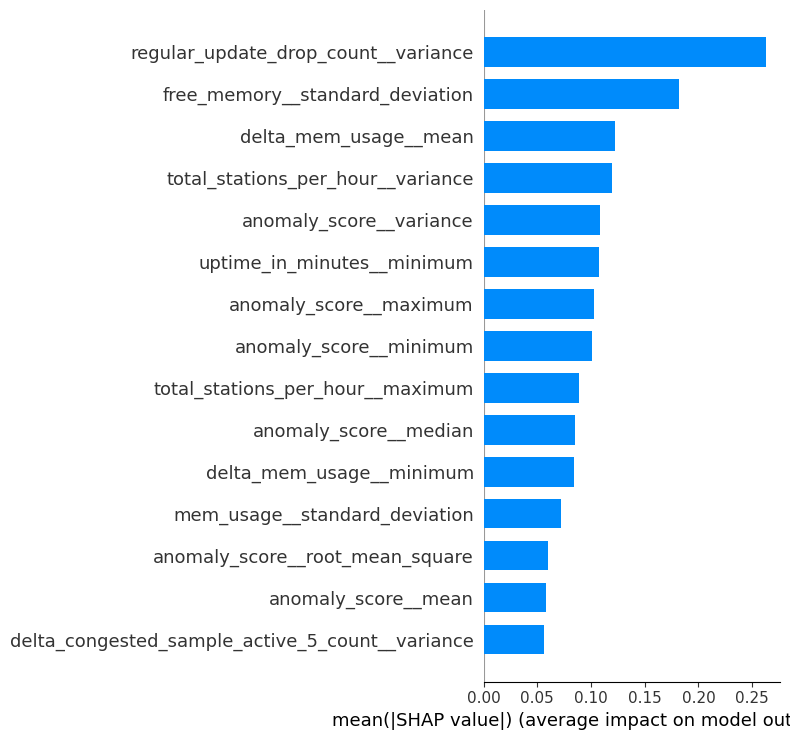

<Figure size 640x480 with 0 Axes>

In [ ]:
from tsfresh.feature_selection.relevance import calculate_relevance_table
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from tsfresh.feature_extraction import MinimalFCParameters
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

# Drop low-variance or NaN-heavy features
X_clean = X_train.dropna(axis=1, thresh=int(0.8 * len(X_train)))

# Drop near-constant
X_clean = X_clean.loc[:, X_clean.std() > 1e-5]

# Univariate relevance filtering
relevance_table = calculate_relevance_table(X_clean, y_train)
relevant_features = relevance_table[relevance_table.relevant == True]["feature"]
X_relevant = X_clean[relevant_features]

# Refit a new model for SHAP
xgb_final = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
)
xgb_final.fit(X_relevant, y_train)

explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(X_relevant)

# Plot
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_relevant, plot_type="bar", max_display=15)
plt.tight_layout()
plt.savefig("shap_summary_clean.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Extract top N features by importance
model.fit(X_train, y_train)

importance = model.feature_importances_
top_n = 189
top_features = X_train.columns[np.argsort(importance)[-top_n:]]
X_selected = X_train[top_features]
print(f"Selected top {top_n} features by XGBoost importance.")

Selected top 189 features by XGBoost importance.


In [ ]:
# Reassign
X_train = X_train[top_features]
X_val = X_val[top_features]
X_test = X_test[top_features]

# Modeling

## Random Forest

In [ ]:
# Compute manual weight
class_counts = Counter(y_train)
total = sum(class_counts.values())

# Inverse frequency or balanced scaling
weight_0 = total / (2 * class_counts[0])
weight_1 = total / (2 * class_counts[1])

# Create dictionary
manual_weights = {0: weight_0, 1: weight_1}


In [ ]:
# Initialize RF model parameters
rf_model = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=3,
    min_samples_split=100,
    min_samples_leaf=50,
    max_features=0.1,
    max_samples=0.6,
    class_weight=manual_weights,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict probabilities
y_val_proba = rf_model.predict_proba(X_val)[:, 1]
y_test_proba = rf_model.predict_proba(X_test)[:, 1]


# Threshold Optimization
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

# Calculate F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

# Find optimal threshold (max F1)
optimal_idx = np.argmax(f1_scores[:-1])  # Exclude last value (edge case)
optimal_threshold = thresholds[optimal_idx]

# Evaluation with Optimal Threshold
# Convert to predicted labels using optimal threshold
y_val_pred_optimal = (y_val_proba >= optimal_threshold).astype(int)
y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

# Also keep original 0.5 threshold for comparison
y_val_pred_default = (y_val_proba >= 0.5).astype(int)
y_test_pred_default = (y_test_proba >= 0.5).astype(int)

# Evaluation function
def evaluate(y_true, y_pred, y_proba, dataset='Validation'):
    print(f"\n{dataset} Performance:")
    print(f"Threshold used    : {optimal_threshold if 'optimal' in dataset.lower() else 0.5}")
    print(f"ROC AUC           : {roc_auc_score(y_true, y_proba):.4f}")
    print(f"PR AUC            : {average_precision_score(y_true, y_proba):.4f}")
    print(f"Accuracy          : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision         : {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall            : {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score          : {f1_score(y_true, y_pred):.4f}")

evaluate(y_val, y_val_pred_optimal, y_val_proba, "Validation (Optimal Threshold)")
evaluate(y_test, y_test_pred_optimal, y_test_proba, "Test (Optimal Threshold)")


Validation (Optimal Threshold) Performance:
Threshold used    : 0.445773855913922
ROC AUC           : 0.4198
PR AUC            : 0.0003
Accuracy          : 0.3302
Precision         : 0.0005
Recall            : 1.0000
F1-Score          : 0.0010

Test (Optimal Threshold) Performance:
Threshold used    : 0.445773855913922
ROC AUC           : 0.6014
PR AUC            : 0.0010
Accuracy          : 0.4059
Precision         : 0.0008
Recall            : 0.7778
F1-Score          : 0.0016


## XGBoost

In [ ]:
# Compute class weight
class_counts = Counter(y_train)

num_negative = class_counts[0]
num_positive = class_counts[1]

scale_pos_weight = num_negative / num_positive

print(f"Class 0 (non-fault): {num_negative}")
print(f"Class 1 (fault): {num_positive}")
print(f"Scale_pos_weight: {scale_pos_weight:.2f}")

Class 0 (non-fault): 18421
Class 1 (fault): 161
Scale_pos_weight: 114.42


In [ ]:
# Initialize the XGBoost model parameters
xgb_model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.02,
    max_depth=3,
    min_child_weight=100,
    gamma=2,
    subsample=0.5,
    colsample_bytree=0.5,
    reg_alpha=5,
    reg_lambda=10,
    scale_pos_weight=scale_pos_weight,
    eval_metric=['auc', 'aucpr'],
    early_stopping_rounds=20,
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    max_bin=128
)

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Predict probabilities
y_val_proba = xgb_model.predict_proba(X_val)[:, 1]
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Automatically find best threshold (F1-score on validation)
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = [f1_score(y_val, (y_val_proba >= t).astype(int), zero_division=0) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n Best threshold from validation set: {best_threshold:.2f} (F1 = {best_f1:.4f})")

# Predict using optimal threshold
y_val_pred = (y_val_proba >= best_threshold).astype(int)
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Evaluation
def evaluate(y_true, y_pred, y_proba, dataset, threshold):
    print(f"\n {dataset} Performance (Threshold = {threshold:.2f}):")
    print(f"ROC AUC  : {roc_auc_score(y_true, y_proba):.4f}")
    print(f"PR AUC   : {average_precision_score(y_true, y_proba):.4f}")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-Score : {f1_score(y_true, y_pred, zero_division=0):.4f}")

evaluate(y_val, y_val_pred, y_val_proba, "Validation", best_threshold)
evaluate(y_test, y_test_pred, y_test_proba, "Test", best_threshold)


 Best threshold from validation set: 0.00 (F1 = 0.0007)

 Validation Performance (Threshold = 0.00):
ROC AUC  : 0.5116
PR AUC   : 0.0007
Accuracy : 0.0003
Precision: 0.0003
Recall   : 1.0000
F1-Score : 0.0007

 Test Performance (Threshold = 0.00):
ROC AUC  : 0.5905
PR AUC   : 0.0010
Accuracy : 0.0006
Precision: 0.0006
Recall   : 1.0000
F1-Score : 0.0012


## CatBoost

In [ ]:
# Count class distribution
counts = Counter(y_train)
num_negative = counts[0]
num_positive = counts[1]

# Inverse frequency method (scale by count)
weight_0 = 1.0
weight_1 = num_negative / num_positive

class_weights = [weight_0, weight_1]
print(f"Class weights: {class_weights}")

Class weights: [1.0, 114.41614906832298]


In [ ]:
# Initialize CatBoost model parameters
cat_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.01,
    depth=3,
    l2_leaf_reg=60,
    bagging_temperature=2.5,
    random_strength=3,
    subsample=0.7,
    grow_policy='Lossguide',
    early_stopping_rounds=100,
    use_best_model=True,
    eval_metric='AUC',
    class_weights=class_weights,
    random_seed=42,
    verbose=100
)

cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)

# Predict probabilities
y_val_proba = cat_model.predict_proba(X_val)[:, 1]
y_test_proba = cat_model.predict_proba(X_test)[:, 1]

# Find optimal threshold (maximize F1 on validation)
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n Best Threshold (Validation F1): {optimal_threshold:.3f} (F1 = {best_f1:.4f})")

# Predict labels using optimal threshold
y_val_pred = (y_val_proba >= optimal_threshold).astype(int)
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

# Evaluation
def evaluate(y_true, y_pred, y_proba, dataset='Validation'):
    print(f"\n {dataset} Performance (Threshold = {optimal_threshold:.3f}):")
    print(f"AUC       : {roc_auc_score(y_true, y_proba):.4f}")
    print(f"PR AUC    : {average_precision_score(y_true, y_proba):.4f}")
    print(f"Accuracy  : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision : {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall    : {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-Score  : {f1_score(y_true, y_pred, zero_division=0):.4f}")

evaluate(y_val, y_val_pred, y_val_proba, "Validation")
evaluate(y_test, y_test_pred, y_test_proba, "Test")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.4623766	best: 0.4623766 (0)	total: 25.1ms	remaining: 2.48s
99:	test: 0.5157226	best: 0.6692173 (5)	total: 1.7s	remaining: 0us

bestTest = 0.6692172502
bestIteration = 5

Shrink model to first 6 iterations.

 Best Threshold (Validation F1): 0.500 (F1 = 0.0014)

 Validation Performance (Threshold = 0.500):
AUC       : 0.6692
PR AUC    : 0.0006
Accuracy  : 0.8048
Precision : 0.0007
Recall    : 0.4000
F1-Score  : 0.0014

 Test Performance (Threshold = 0.500):
AUC       : 0.6720
PR AUC    : 0.0016
Accuracy  : 0.7543
Precision : 0.0014
Recall    : 0.5556
F1-Score  : 0.0027


## LigthGBM

In [ ]:
# Compute class weight
n_pos = sum(y_train == 1)
n_neg = sum(y_train == 0)
scale_pos_weight = n_neg / max(1, n_pos)

print(f"Class balance — Neg: {n_neg}, Pos: {n_pos}, scale_pos_weight: {scale_pos_weight:.2f}")

Class balance — Neg: 18421, Pos: 161, scale_pos_weight: 114.42


In [ ]:
# Prepare LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
lgb_val   = lgb.Dataset(X_val, label=y_val, reference=lgb_train, free_raw_data=False)

# Initialize LightGBM model parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 4,
    'max_depth': 2,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'min_data_in_leaf': 200,
    'lambda_l1': 5.0,
    'lambda_l2': 10.0,
    'extra_trees': True,
    'scale_pos_weight': scale_pos_weight,
    'verbosity': -1,
    'random_state': 42
}


# Train model
evals_result = {}  # define it

lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=300,
    valid_sets=[lgb_train, lgb_val],  # include both sets
    valid_names=['train', 'val'],
    callbacks=[
        lgb.record_evaluation(evals_result),
        lgb.early_stopping(stopping_rounds=30, verbose=True)
    ]
)



# Predict probabilities
y_val_pred_prob = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
y_test_pred_prob = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# Search best threshold on validation set
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []
for thresh in thresholds:
    preds = (y_val_pred_prob > thresh).astype(int)
    f1 = f1_score(y_val, preds, zero_division=0)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n Best threshold from validation set: {best_thresh:.2f} (F1: {best_f1:.4f})")

# Apply best threshold to val and test sets
y_val_pred_opt = (y_val_pred_prob > best_thresh).astype(int)
y_test_pred_opt = (y_test_pred_prob > best_thresh).astype(int)

# Define a function to print metrics
def print_metrics(name, y_true, y_pred, y_proba):
    print(f"\n {name} Set Metrics (Threshold = {best_thresh:.2f}):")
    print(f"ROC AUC     : {roc_auc_score(y_true, y_proba):.4f}")
    print(f"PR AUC      : {average_precision_score(y_true, y_proba):.4f}")
    print(f"Accuracy    : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision   : {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall      : {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-Score    : {f1_score(y_true, y_pred, zero_division=0):.4f}")

print_metrics("Validation", y_val, y_val_pred_opt, y_val_pred_prob)
print_metrics("Test", y_test, y_test_pred_opt, y_test_pred_prob)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.642262	val's auc: 0.50899

 Best threshold from validation set: 0.02 (F1: 0.0007)

 Validation Set Metrics (Threshold = 0.02):
ROC AUC     : 0.5090
PR AUC      : 0.0006
Accuracy    : 0.0030
Precision   : 0.0003
Recall      : 1.0000
F1-Score    : 0.0007

 Test Set Metrics (Threshold = 0.02):
ROC AUC     : 0.5846
PR AUC      : 0.0008
Accuracy    : 0.0011
Precision   : 0.0006
Recall      : 1.0000
F1-Score    : 0.0012
